### Import Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import altair as alt
import pywt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [2]:
filename = 'aavash1'
filepath = './Data/Processed Data/'+f'{filename}'+'_processed.csv'

SUBCARRIES_NUM = 52

In [3]:
# data = pd.read_csv(filepath, header=None).values
# df = pd.DataFrame(data)
# display(df)

In [4]:
# https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/sys031fp.pdf
# Based on https://github.com/ermongroup/Wifi_Activity_Recognition/.../phase_calibration.m
def calibrate_single_phase(phases):
    phases = np.array(phases)
    difference = 0

    calibrated_phase, calibrated_phase_final = np.zeros_like(phases), np.zeros_like(phases)   
    calibrated_phase[0] = phases[0]
    
    phases_len = phases.shape[0]
    
    for i in range(1, phases_len):
        temp = phases[i]- phases[i - 1]
        
        if abs(temp) > np.pi:
            difference = difference + 1*np.sign(temp)
            
        calibrated_phase[i] = phases[i] - difference * 2 * np.pi
        
    k = (calibrated_phase[-1] - calibrated_phase[0]) / (phases_len - 1)
    b = np.mean(calibrated_phase)
    
    for i in range(phases_len):
        calibrated_phase_final[i] = calibrated_phase[i] - k * i - b
        
    return calibrated_phase_final


def calibrate_phase(phases):
    calibated_phases = np.zeros_like(phases)
    
    for i in range(phases.shape[0]):
        calibated_phases[i] = calibrate_single_phase(np.unwrap(phases[i]))
    
    return calibated_phases

def calibrate_amplitude(amplitudes, rssi=1): # Basic statistical normalization
    amplitudes = np.array(amplitudes)    
    return ((amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes))) * rssi

In [5]:
def read_csi_data_from_csv(path_to_csv):
    file = pd.read_csv(path_to_csv, header=None).values
    data = pd.DataFrame(file).apply(pd.to_numeric, errors='coerce').values
    data = np.nan_to_num(data)
    # data_len = data.shape[0]
    antenna_pair = 1
    # display(data_len)
    subcarries_num = SUBCARRIES_NUM
    amplitudes = data[:, subcarries_num*1:subcarries_num*(1 + antenna_pair)]
    amp_dat = pd.DataFrame(amplitudes)
    display(amp_dat)
    display(len(amp_dat.columns))
    phases = data[:, subcarries_num*(1 + antenna_pair):subcarries_num*(1 + 2*antenna_pair)]
    phase_dat = pd.DataFrame(phases)
    display(phase_dat)
    return amplitudes, phases

In [45]:
experiments_data = []
amplitudes, phases = read_csi_data_from_csv(filepath)
experiments_data.append([amplitudes, phases])
# display(experiments_data[0][0][0])

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,210.342578,283.622989,318.025156,273.738927,164.684547,88.102213,228.740027,454.394102,628.411489,749.230272,...,542.071951,685.631096,821.922746,933.332202,956.174147,943.716059,855.851623,690.047100,494.494692,234.795656
1,461.885267,595.242808,696.715867,697.906154,654.129192,634.527383,473.769986,426.957843,357.531817,323.562977,...,666.985007,587.766110,463.314148,382.989556,321.547819,305.221231,401.997512,461.061818,483.566955,377.025198
2,362.829161,497.321827,538.075274,599.287911,530.292372,431.551851,327.844475,262.611881,237.033753,252.675681,...,668.025449,556.118692,484.753546,225.079986,242.942380,206.293480,290.270563,284.344861,351.445586,271.140185
3,345.950864,534.804637,590.181328,638.376848,598.579151,541.089641,373.108563,403.209623,280.178515,213.740497,...,546.772348,453.788497,361.653149,323.904307,291.979451,280.016071,299.813275,375.366488,336.005952,298.933103
4,479.087675,680.294054,686.865343,674.329296,514.186737,552.000906,645.864537,495.827591,435.690257,355.877788,...,876.132981,680.036028,502.152367,302.790357,237.103353,242.736483,389.178622,519.849978,481.702190,416.828502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,93.300589,87.281155,120.619236,255.431008,398.327754,549.421514,727.782935,766.381759,875.334222,876.002283,...,796.276962,813.910314,809.504169,763.000655,696.916781,629.584784,561.918144,442.485028,333.061556,180.113853
2233,339.330223,453.357475,565.099991,626.278692,621.579440,616.525750,600.201633,564.932739,552.602932,528.503548,...,624.945598,487.315093,440.477014,262.345192,341.502562,294.278779,458.981481,419.672491,438.511117,314.682380
2234,223.008968,165.583816,269.356641,292.385020,380.539091,483.321839,562.211704,679.155358,768.417204,830.086742,...,642.059187,639.282410,682.586991,763.288936,730.529945,724.189202,724.859297,636.440099,520.947214,291.382910
2235,197.253644,324.722959,256.908544,195.432853,284.114414,196.420467,137.931142,261.629509,436.033256,406.509532,...,332.453004,341.344401,358.468967,404.969135,188.281704,294.187015,294.187015,148.660687,219.822656,164.012195


52

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,-0.057081,-0.180800,-0.656079,-1.125121,-1.479587,-0.458572,-0.260884,-0.741812,-1.263640,-1.825810,...,-1.368336,-2.188333,-2.944436,2.580040,1.959071,1.302686,0.654485,0.055097,-0.499831,-1.312389
1,1.716368,0.028564,-0.988765,-2.126206,3.121718,1.999902,0.791368,-0.136266,-0.970382,-1.827019,...,-2.102216,3.090530,2.036374,1.263083,0.460866,-0.271999,-0.958644,-1.895290,-2.834883,1.790041
2,-1.407460,-3.044925,2.151067,1.067588,-0.069830,-1.410219,-2.481620,2.934489,2.197421,0.974012,...,1.515381,0.295590,-0.718248,-1.597457,-2.648488,-3.088245,2.192247,1.300226,0.191815,-1.445069
3,-0.382117,-1.954080,-2.914286,2.293016,1.327844,0.424792,-0.667625,-1.538549,-2.178598,-2.871648,...,0.398168,-0.536640,-1.339231,-2.338729,-2.625845,3.130879,2.356194,1.485443,0.637549,-0.549025
4,-1.889247,-2.638492,-2.812476,-3.058451,2.821072,2.496280,2.578070,2.380441,2.378918,2.611293,...,-3.044423,-3.131299,3.073832,-2.664652,-3.112065,-2.624490,-2.654961,-2.572798,-2.692800,2.464978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,-1.875599,1.885301,1.362019,0.105902,-1.146454,-2.242695,2.874618,1.630855,0.512203,-0.641218,...,-2.550107,2.481627,1.222870,-0.001311,-1.276728,-2.554031,2.548654,1.229749,-0.111320,-1.682067
2233,-2.830093,2.880564,2.136711,1.673166,0.775160,0.245765,-0.641169,-1.126149,-1.851333,-2.294610,...,3.003543,2.452109,1.827889,0.777312,0.093841,-1.098030,-1.636205,-2.479505,-2.902145,2.367430
2234,1.358450,0.596378,0.495199,0.051325,-0.246891,-0.500668,-0.873553,-1.136126,-1.312876,-1.585253,...,2.351789,2.008557,1.686792,1.376998,1.082047,0.802974,0.568105,0.254125,-0.086489,-0.804813
2235,2.016305,2.089560,2.606514,-2.680233,-1.949342,-0.563996,0.116262,1.098602,2.034444,2.584297,...,-0.715151,-0.521326,0.526066,0.996491,1.757776,2.953530,2.953530,-0.832981,-1.657338,-0.915101


In [46]:
def hampel(vals_orig, k=3, t0=123, outliers_return=False):
    vals = pd.Series(vals_orig.copy())

    #Hampel Filter
    L= 1.4826
    
    rolling_median=vals.rolling(k).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(k).median()
    threshold= t0 *L * median_abs_deviation
    outlier_idx=difference>threshold
    vals[outlier_idx]=rolling_median
    
    if outliers_return:
        return vals, outlier_idx

    return vals

def dwn_noise(vals, th=0.19):
    threshold = th # Threshold for filtering

    data = vals.copy()
#     print("data: ", data.shape)

    w = pywt.Wavelet('sym5')
    maxlev = pywt.dwt_max_level(data.shape[0], w.dec_len)
#     print("maximum level is " + str(maxlev))
    
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, 'sym5', level=maxlev)
    
#     plt.figure()
    for i in range(1, len(coeffs)):
#         plt.subplot(maxlev, 1, i)
#         plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
#         plt.plot(coeffs[i])

    datarec = pywt.waverec(coeffs, 'sym5')
    
    return datarec

def noise_reduction_all_subcarriers(amplitudes):
    data_len = amplitudes.shape[0]
    
    res = np.zeros_like(amplitudes)

    for i in range(amplitudes.shape[1]):
        res[:data_len, i] = dwn_noise(hampel(amplitudes[:, i]))[:data_len]
        
    return res

def hampel_all_subcarriers(amplitudes, k=3, t0=123):
    data_len = amplitudes.shape[0]
    
    res = np.zeros_like(amplitudes)
    outliers = []

    for i in range(amplitudes.shape[1]):
        res[:data_len, i], out = hampel(amplitudes[:, i], k, t0, outliers_return=True)[:data_len]
        outliers.append(out)
        
    return res, outliers

def cwt_all_subcarriers(amplitudes, th=0.19):
    data_len = amplitudes.shape[0]
    
    res = np.zeros_like(amplitudes)
    
    for i in range(amplitudes.shape[1]):
        res[:data_len, i] = dwn_noise(amplitudes[:, i], th)[:data_len]
        
    return res


def annotation_line( ax, xmin, xmax, y, text, ytext=0, linecolor='black', linewidth=1, fontsize=12 ):

    ax.annotate('', xy=(xmin, y), xytext=(xmax, y), xycoords='data', textcoords='data', annotation_clip=False,
            arrowprops={'arrowstyle': '|-|', 'color':linecolor, 'linewidth':linewidth})
    
    ax.annotate('', xy=(xmin, y), xytext=(xmax, y), xycoords='data', textcoords='data', annotation_clip=False,
            arrowprops={'arrowstyle': '<->', 'color':linecolor, 'linewidth':linewidth})

    xcenter = xmin + (xmax-xmin)/2
    if ytext == 0:
        ytext = y + ( ax.get_ylim()[1] - ax.get_ylim()[0] ) / 20

    ax.annotate(text, xy=(xcenter,ytext), ha='center', va='center', fontsize=fontsize, annotation_clip=False)

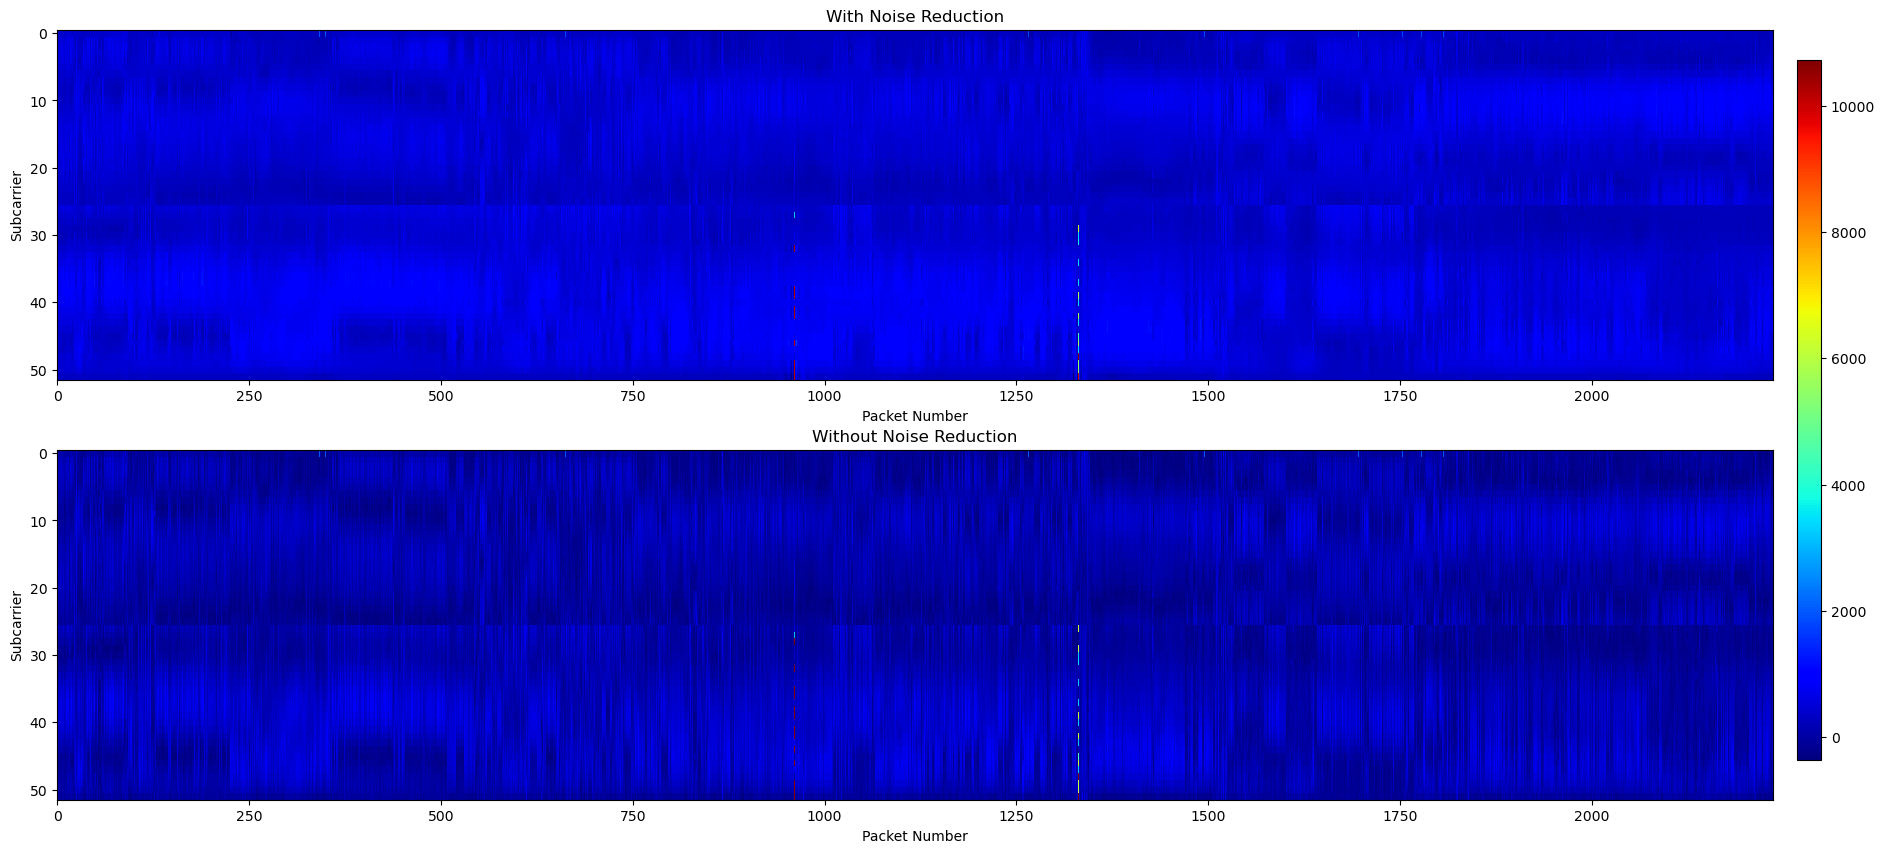

In [47]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# from mpl_toolkits.axes_grid1.colorbar import colorbar

fig = plt.figure(figsize = (24,10))
ax = fig.add_subplot(211)
im = plt.imshow(noise_reduction_all_subcarriers(experiments_data[0][0][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax.set_title("With Noise Reduction")
# annotation_line(ax, text='Aavash1', xmin=650, xmax=1760, y=60, ytext=62, linewidth=1, linecolor='black', fontsize=14)
# plt.colorbar(im, ax=ax)

# fig1 = plt.figure(figsize = (24,10))
ax1 = fig.add_subplot(212)
im1 = plt.imshow((experiments_data[0][0][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Without Noise Reduction")
# annotation_line(ax, text='Aavash1', xmin=650, xmax=1760, y=60, ytext=62, linewidth=1, linecolor='black', fontsize=14)
# plt.colorbar(im1, ax=ax1)
# Turn off axis lines and ticks of the big subplot
# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('Subcarrier')
ax.set_xlabel('Packet Number')
ax1.set_ylabel('Subcarrier')
ax1.set_xlabel('Packet Number')
# fig.suptitle('Channels comparison for 1-to-1 antenna pair (filtered data)', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Subcarrier Plot for Single Subcarrier with and without filtering

### Without Filtering

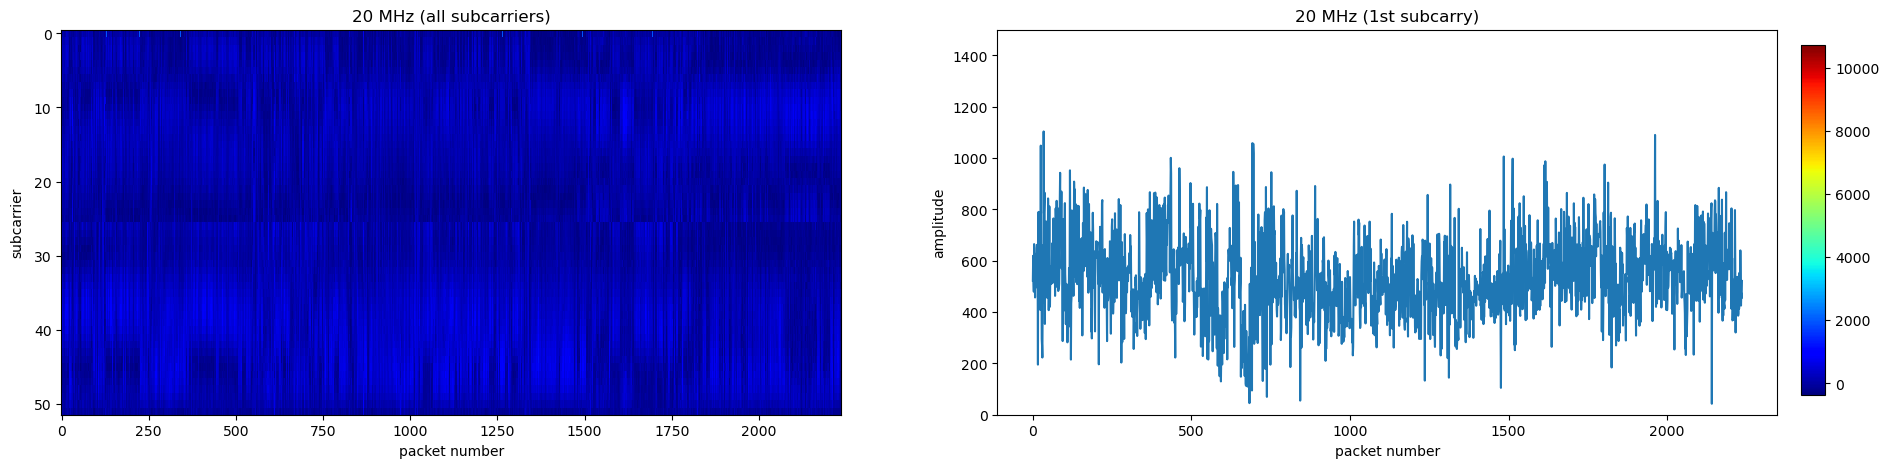

In [48]:
fig = plt.figure(figsize = (24,5))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(121)
plt.imshow((experiments_data[0][0][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("20 MHz (all subcarriers)")

ax3 = fig.add_subplot(122)
plt.plot((experiments_data[0][0][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM])[:, 15])
ax3.set_title("20 MHz (1st subcarry)")
plt.ylim(0, 1500)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax1.set_xlabel('packet number')
ax3.set_ylabel('amplitude')
ax3.set_xlabel('packet number')

# fig.suptitle('Channels bandwidth comparison (no activity) for 1-to-1 antenna pair', fontsize=23)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

### With Filtering

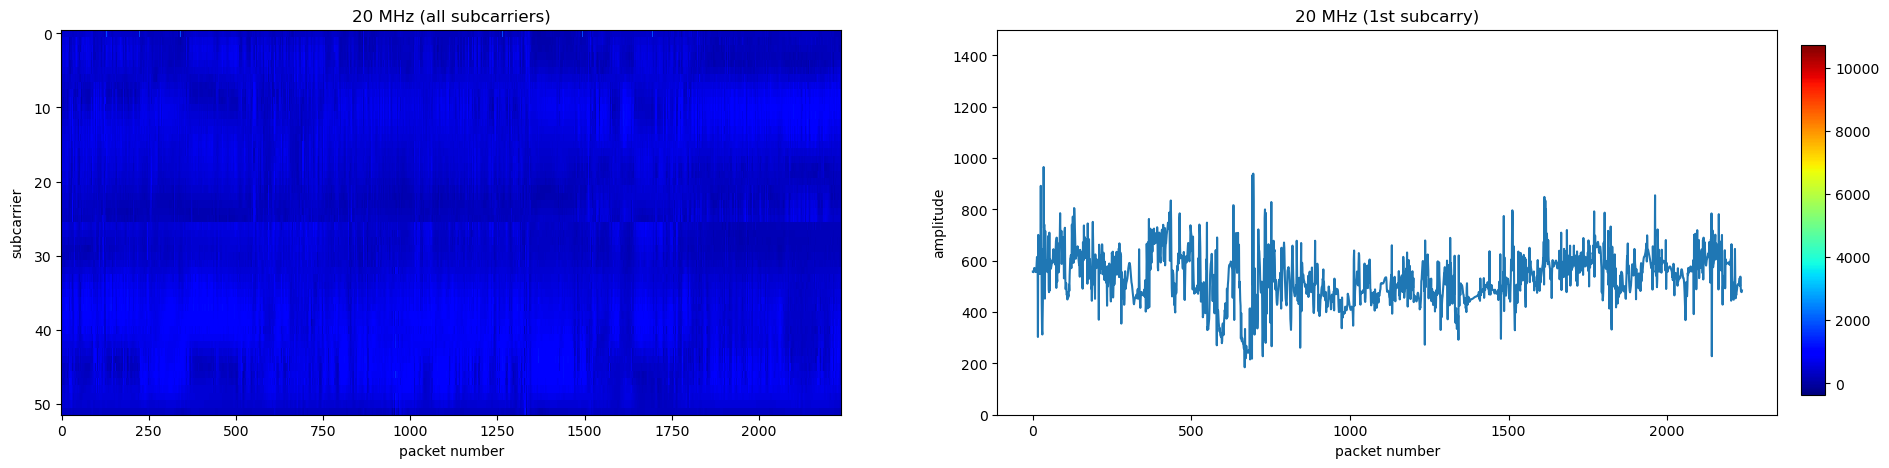

In [49]:
fig = plt.figure(figsize = (24, 5))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(121)
plt.imshow(noise_reduction_all_subcarriers(experiments_data[0][0][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("20 MHz (all subcarriers)")

ax3 = fig.add_subplot(122)
plt.plot(noise_reduction_all_subcarriers(experiments_data[0][0][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM])[:, 15])
ax3.set_title("20 MHz (1st subcarry)")
plt.ylim(0, 1500)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax1.set_xlabel('packet number')
ax3.set_ylabel('amplitude')
ax3.set_xlabel('packet number')

# fig.suptitle('Channels bandwidth comparison (activity) for 1-to-1 antenna pair', fontsize=23)
# fig.tight_layout(pad=3)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Preprocessing Visualization

### 1. Phase Sanitization

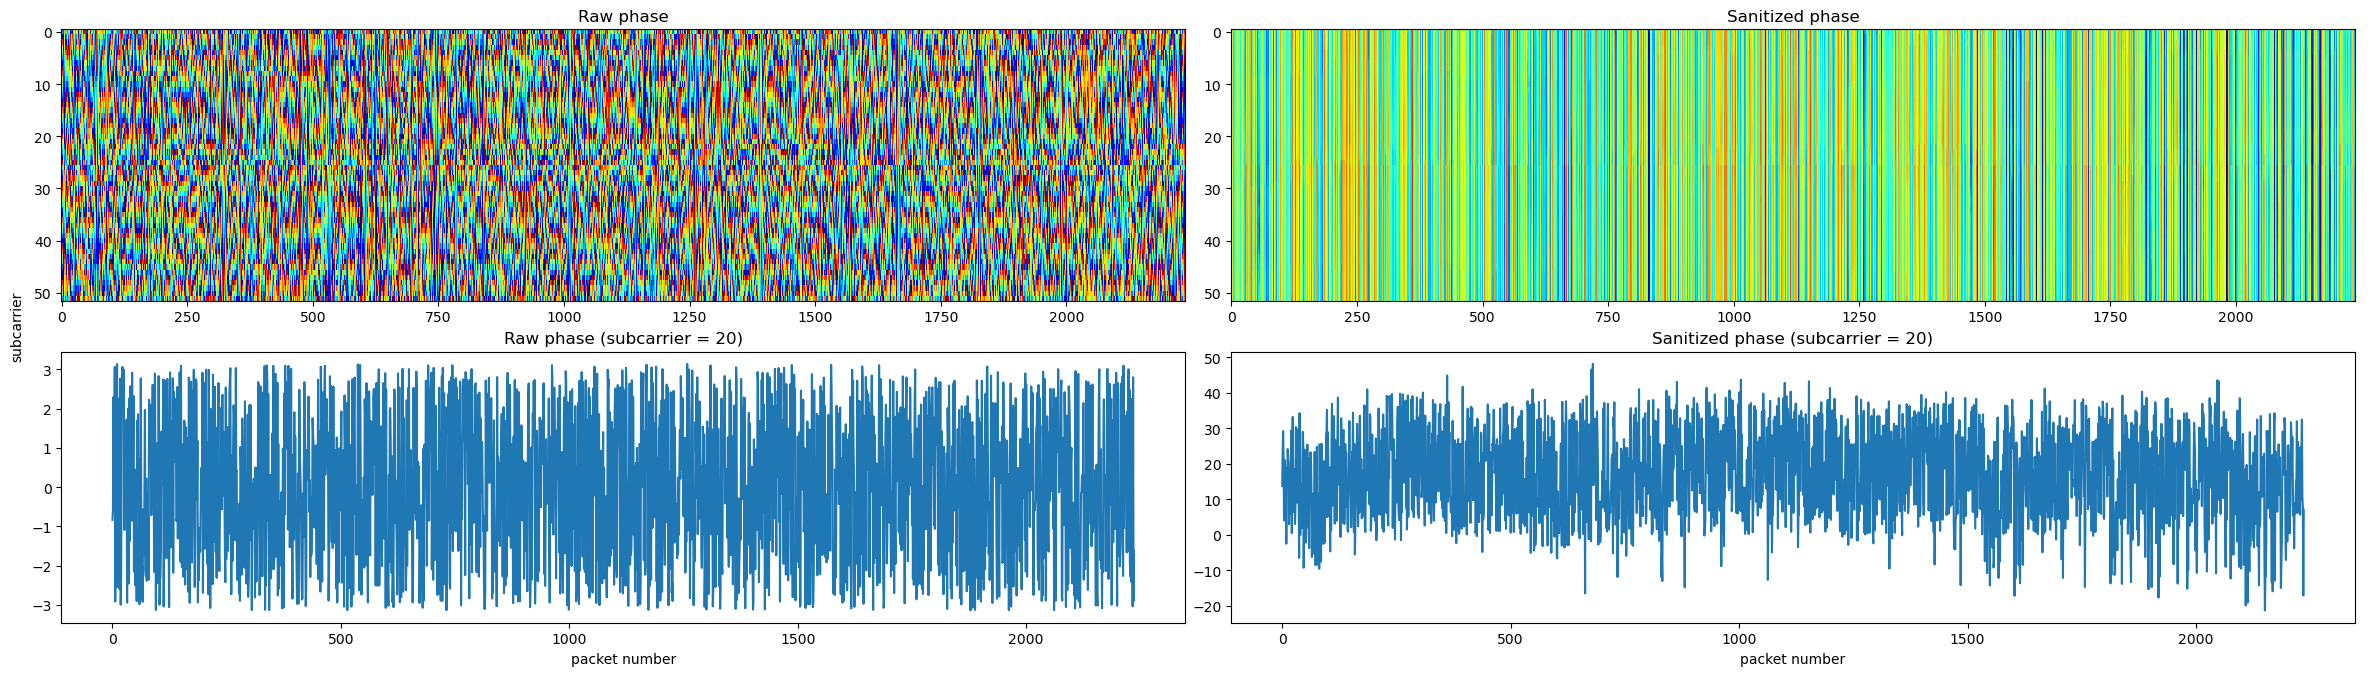

In [50]:
fig = plt.figure(figsize = (24, 7))
ax = fig.add_subplot(111)

ax1 = fig.add_subplot(221)
im = plt.imshow((experiments_data[0][1][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw phase")
# plt.colorbar()

ax2 = fig.add_subplot(222)
im = plt.imshow(calibrate_phase(experiments_data[0][1][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM]).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Sanitized phase")
# plt.colorbar()

ax3 = fig.add_subplot(223)
plt.plot((experiments_data[0][1][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM])[:, 20])
ax3.set_title("Raw phase (subcarrier = 20)")

ax4 = fig.add_subplot(224)
plt.plot(calibrate_phase(experiments_data[0][1][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM])[:, 20])
ax4.set_title("Sanitized phase (subcarrier = 20)")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

# fig.suptitle('WiFi 2.4 vs 5 HHz frequency for 1-to-1 antenna pair', fontsize=23)
fig.tight_layout(pad=0.5)

plt.show()

### 2. Hampler Identifier Identification

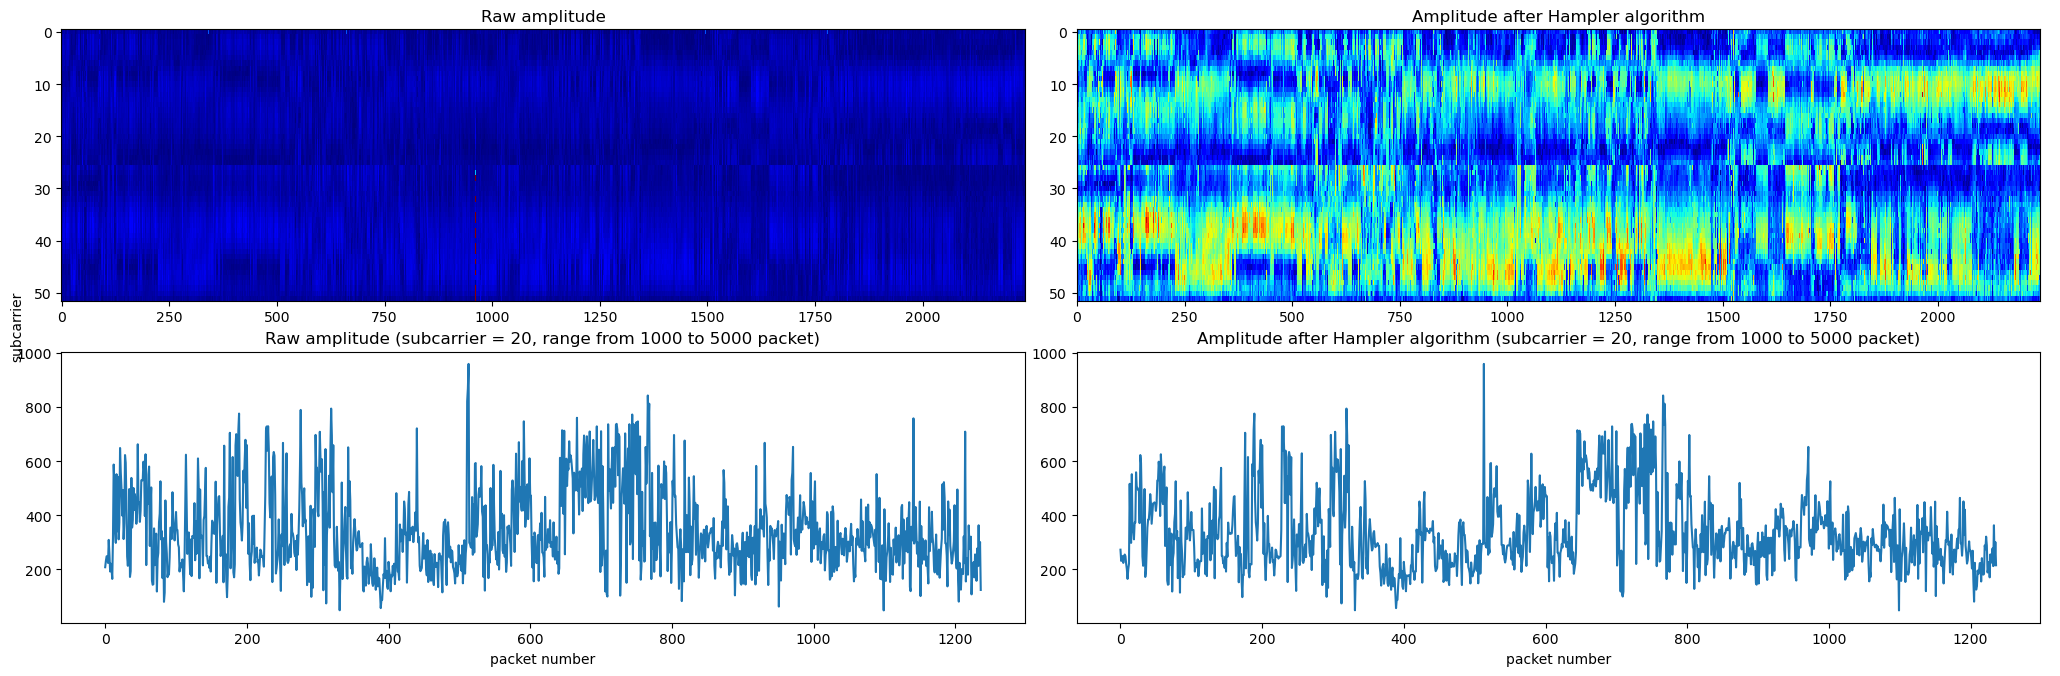

In [51]:
fig = plt.figure(figsize = (21, 7))
ax = fig.add_subplot(111)

amplitude = experiments_data[0][0][:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM]
h_amplitude, outliers = hampel_all_subcarriers(amplitude, k=5, t0=2)

ax1 = fig.add_subplot(221)
im = plt.imshow((amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw amplitude")

ax2 = fig.add_subplot(222)
im = plt.imshow(h_amplitude.T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Amplitude after Hampler algorithm")

ax3 = fig.add_subplot(223)
plt.plot((amplitude)[1000:5000, 20])
ax3.set_title("Raw amplitude (subcarrier = 20, range from 1000 to 5000 packet)")

ax4 = fig.add_subplot(224)
plt.plot(h_amplitude[1000:5000, 20])
ax4.set_title("Amplitude after Hampler algorithm (subcarrier = 20, range from 1000 to 5000 packet)")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

fig.tight_layout(pad=0.5)
plt.show()

In [52]:
(outliers[20].to_numpy().sum())

326

### 3. CWT Noise Reduction

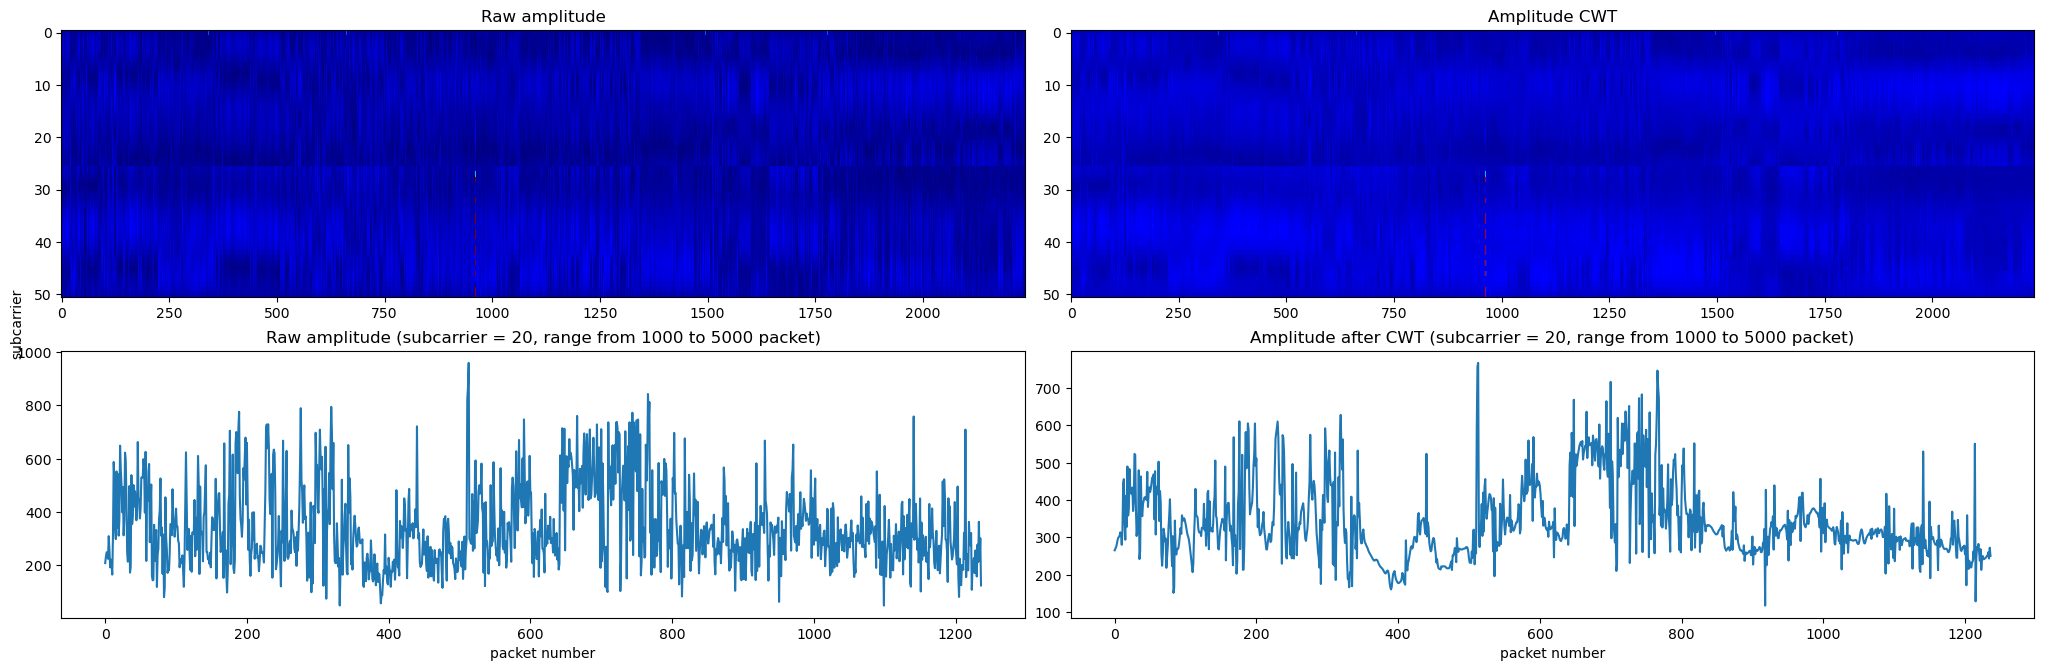

In [62]:
dataset_amp = experiments_data[0][0][:, 0:51]
dataset_amp.shape

fig = plt.figure(figsize = (21, 7))
ax = fig.add_subplot(111)

amplitude = dataset_amp[:, 0*SUBCARRIES_NUM:1*SUBCARRIES_NUM]
cwt_amplitude = cwt_all_subcarriers(amplitude, th=0.2)

ax1 = fig.add_subplot(221)
im = plt.imshow((amplitude).T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Raw amplitude")

ax2 = fig.add_subplot(222)
im = plt.imshow(cwt_amplitude.T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax2.set_title("Amplitude CWT")

ax3 = fig.add_subplot(223)
plt.plot((amplitude)[1000:5000, 20])
ax3.set_title("Raw amplitude (subcarrier = 20, range from 1000 to 5000 packet)")

ax4 = fig.add_subplot(224)
plt.plot(cwt_amplitude[1000:5000, 20])
ax4.set_title("Amplitude after CWT (subcarrier = 20, range from 1000 to 5000 packet)")

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_ylabel('subcarrier')
ax3.set_xlabel('packet number')
ax4.set_xlabel('packet number')

fig.tight_layout(pad=0.7)
plt.show()